In [1]:
import syft as sy
import time
import numpy as np
import pandas as pd
from opacus import PrivacyEngine
from opacus.utils.uniform_sampler import UniformWithReplacementSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from collections import OrderedDict

### Establish connection

In [2]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 8, 2, padding=3)
        self.conv2 = nn.Conv2d(16, 32, 4, 2)
        self.fc1 = nn.Linear(32 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = F.relu(self.conv1(x))  # -> [B, 16, 14, 14]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 16, 13, 13]
        x = F.relu(self.conv2(x))  # -> [B, 32, 5, 5]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 32, 4, 4]
        x = x.view(-1, 32 * 4 * 4)  # -> [B, 512]
        x = F.relu(self.fc1(x))  # -> [B, 32]
        x = self.fc2(x)  # -> [B, 10]
        return x

In [3]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    criterion = nn.CrossEntropyLoss()
    losses = []
    for _batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        epsilon, best_alpha = optimizer.privacy_engine.get_privacy_spent(1e-5)
        print(
            f"Train Epoch: {epoch} \t"
            f"Loss: {np.mean(losses):.6f} "
            f"(ε = {epsilon:.2f}, δ = 1e-5) for α = {best_alpha}"
        )

In [4]:
def test(model, device, test_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in (test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )
    return test_loss, correct / len(test_loader.dataset)

In [5]:
class MnistDataset(torch.utils.data.Dataset):
    def __init__(self, data_path):
        # data loading
        df = pd.read_csv(data_path, dtype=np.float64)
        self.x = torch.from_numpy(df.iloc[:,1:].values)
        
        self.x = self.x.reshape(self.x.size(0),1,28,28)
        self.x = self.x.float() # why float?
        
        self.y = torch.from_numpy(df.iloc[:,0].values) 
        self.y = self.y.long() # why long?
        
        self.n_samples = df.shape[0]
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [6]:
start = time.time()

train_dataset = MnistDataset("C:/Users/dells/FMNIST/dataset/.client_1_train_data.csv")
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_sampler=UniformWithReplacementSampler(
            num_samples=len(train_dataset),
            sample_rate=0.004,
        ),
    )

test_dataset = MnistDataset("C:/Users/dells/FMNIST/dataset/.client_1_test_data.csv")
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64,shuffle=True)

global_test = MnistDataset("C:/Users/dells/FMNIST/dataset/fashion-mnist_test.csv")
global_test_loader = torch.utils.data.DataLoader(dataset=global_test, batch_size=64,shuffle=True)

end = time.time()

In [7]:
print(f"Take dataset time: {float(end - start)} seconds")  

Take dataset time: 4.550827741622925 seconds


In [8]:
start = time.time()

use_cuda = not False and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

end = time.time()

In [9]:
print(f"Check device time: {float(end - start)} seconds")  

Check device time: 0.23599457740783691 seconds


In [10]:
start = time.time()

model = Classifier().to(device)

end = time.time()

In [11]:
print(f"Create model time: {float(end - start)} seconds")

Create model time: 1.965998888015747 seconds


In [12]:
start = time.time()
optimizerLR = optim.SGD(model.parameters(), lr=0.01, momentum=0)
model.train()
privacy_engine = PrivacyEngine(
                model,
                sample_rate=0.004,
                alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
                noise_multiplier=1.0,
                max_grad_norm=1.0,
            )
privacy_engine.attach(optimizerLR)
end = time.time()

C:\Users\dells\anaconda3\lib\site-packages\opacus\privacy_engine.py:645: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  warnings.warn(
C:\Users\dells\anaconda3\lib\site-packages\opacus\privacy_engine.py:229: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  warnings.warn(


In [13]:
print(f"Attach DP module into optimizer: {float(end - start)} seconds")

Attach DP module into optimizer: 0.0029981136322021484 seconds


In [218]:
start = time.time()

for epoch in range(1, 11):
    train(model, device, train_loader, optimizerLR, epoch)
    test(model, device, test_loader)
    
end = time.time()

C:\Users\dells\anaconda3\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [219]:
print(f"Training time: {float(end - start)} seconds")  

Training time: 124.64678382873535 seconds


In [220]:
start = time.time()

torch.save(model.state_dict(), "mnist_ann1.pt")

end = time.time()

In [221]:
print(f"Saving time: {float(end - start)} seconds")  

In [222]:
start = time.time()

load_model = torch.load('mnist_ann1.pt')

end = time.time()

In [223]:
print(f"Load params time: {float(end - start)} seconds")

Load params time: 0.017000198364257812 seconds


In [224]:
start = time.time()

conv1_weight = load_model["conv1.weight"].tolist()
conv1_bias = load_model["conv1.bias"].tolist()

conv2_weight = load_model["conv2.weight"].tolist()
conv2_bias = load_model["conv2.bias"].tolist()

fc1_weight = load_model["fc1.weight"].tolist()
fc1_bias = load_model["fc1.bias"].tolist()

fc2_weight = load_model["fc2.weight"].tolist()
fc2_bias = load_model["fc2.bias"].tolist()

end = time.time()

In [225]:
print(f"Take w+b time: {float(end - start)} seconds")

Take w+b time: 0.005998134613037109 seconds


### Checkpoint 0

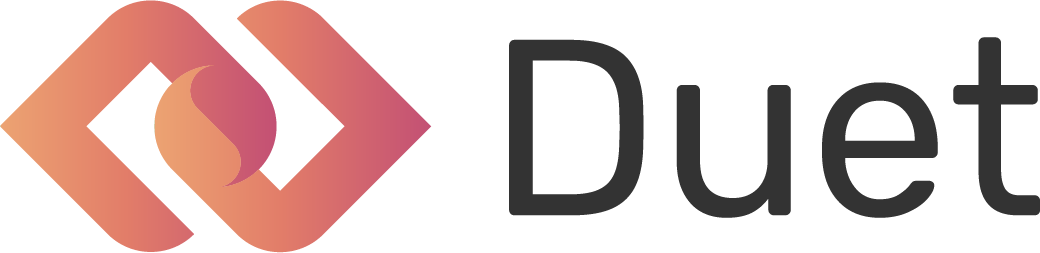

In [226]:
duet = sy.launch_duet(loopback=True)

In [227]:
start = time.time()

conv1_weight_ptr = sy.lib.python.List(conv1_weight).send(duet, pointable=True, tags=["conv1_weight"])
conv1_bias_ptr = sy.lib.python.List(conv1_bias).send(duet, pointable=True, tags=["conv1_bias"])
conv2_weight_ptr = sy.lib.python.List(conv2_weight).send(duet, pointable=True, tags=["conv2_weight"])
conv2_bias_ptr = sy.lib.python.List(conv2_bias).send(duet, pointable=True, tags=["conv2_bias"])
fc1_weight_ptr = sy.lib.python.List(fc1_weight).send(duet, pointable=True, tags=["fc1_weight"])
fc1_bias_ptr = sy.lib.python.List(fc1_bias).send(duet, pointable=True, tags=["fc1_bias"])
fc2_weight_ptr = sy.lib.python.List(fc2_weight).send(duet, pointable=True, tags=["fc2_weight"])
fc2_bias_ptr = sy.lib.python.List(fc2_bias).send(duet, pointable=True, tags=["fc2_bias"])

end = time.time()

In [228]:
print(f"Send params time: {float(end - start)} seconds")

Send params time: 4.938186407089233 seconds


In [229]:
duet.store.pandas

,ID,Tags,Description,object_type
0,<UID: a2e7cf7829214d2d863757d5de2693d3>,[conv1_weight],,<class 'syft.lib.python.list.List'>
1,<UID: ba12964d4d2441b1a744b1104c9cb74c>,[conv1_bias],,<class 'syft.lib.python.list.List'>
2,<UID: 20f6ab49ac884c67b85b80f18eb5d287>,[conv2_weight],,<class 'syft.lib.python.list.List'>
3,<UID: baa49aa2637246fa840a1090cabca55d>,[conv2_bias],,<class 'syft.lib.python.list.List'>
4,<UID: c567bd4e18ae431f96e68efc111efd15>,[fc1_weight],,<class 'syft.lib.python.list.List'>
5,<UID: 49dd58eefc7d4d8383bef4bd7d89efbc>,[fc1_bias],,<class 'syft.lib.python.list.List'>
6,<UID: e0869dbda8254f1aaad451c54c89b176>,[fc2_weight],,<class 'syft.lib.python.list.List'>
7,<UID: f3abc9c125264f179a715ed9c7d98bbf>,[fc2_bias],,<class 'syft.lib.python.list.List'>


### Checkpoint 1

In [230]:
duet.requests.pandas

,Requested Object's tags,Reason,Request ID,Requested Object's ID,Requested Object's type
0,[conv1_weight],I would like to get the conv1 weight,<UID: c4e5dd72ddba493397a8e22fcbf1129c>,<UID: a2e7cf7829214d2d863757d5de2693d3>,<class 'syft.lib.python.list.List'>
1,[conv1_bias],I would like to get the conv1 bias,<UID: 4e2ac984c1b64c618975552735497434>,<UID: ba12964d4d2441b1a744b1104c9cb74c>,<class 'syft.lib.python.list.List'>
2,[conv2_weight],I would like to get the conv2 weight,<UID: 4ae08cb9fe3e428cab01308d955dd206>,<UID: 20f6ab49ac884c67b85b80f18eb5d287>,<class 'syft.lib.python.list.List'>
3,[conv2_bias],I would like to get the conv2 bias,<UID: 80e631755fcc4c1b8d530a643751decb>,<UID: baa49aa2637246fa840a1090cabca55d>,<class 'syft.lib.python.list.List'>
4,[fc1_weight],I would like to get the fc1 weight,<UID: 5ee900d5f0c94b22839fae7bc0e3ff45>,<UID: c567bd4e18ae431f96e68efc111efd15>,<class 'syft.lib.python.list.List'>
5,[fc1_bias],I would like to get the fc1 bias,<UID: e738ad749e9945e190437ba59336d958>,<UID: 49dd58eefc7d4d8383bef4bd7d89efbc>,<class 'syft.lib.python.list.List'>
6,[fc2_weight],I would like to get the fc2 weight,<UID: 4c3e1478707b42babfff3068bce1ed64>,<UID: e0869dbda8254f1aaad451c54c89b176>,<class 'syft.lib.python.list.List'>
7,[fc2_bias],I would like to get the fc2 bias,<UID: 20ade0c3c3914392ad5cc3dd11c2a27b>,<UID: f3abc9c125264f179a715ed9c7d98bbf>,<class 'syft.lib.python.list.List'>


In [231]:
duet.requests[0].accept()
duet.requests[0].accept()
duet.requests[0].accept()
duet.requests[0].accept()
duet.requests[0].accept()
duet.requests[0].accept()
duet.requests[0].accept()
duet.requests[0].accept()

### Checkpoint 2

In [232]:
duet.store.pandas

,ID,Tags,Description,object_type
0,<UID: c8ac184b2cf14797b35684c485f429ee>,[global_conv1_weight],,<class 'syft.lib.python.list.List'>
1,<UID: 6b1f78957f0a4227b38905f335553b12>,[global_conv1_bias],,<class 'syft.lib.python.list.List'>
2,<UID: 32a73769699549b5bb6afb17ee624cc6>,[global_conv2_weight],,<class 'syft.lib.python.list.List'>
3,<UID: fd5883dd789046bfbbb6bb8dda3b7e17>,[global_conv2_bias],,<class 'syft.lib.python.list.List'>
4,<UID: 41df7d387b7d4540bada20e2ad5cbf98>,[global_fc1_weight],,<class 'syft.lib.python.list.List'>
5,<UID: f24696ce572e4743ad93fa9a662ecec7>,[global_fc1_bias],,<class 'syft.lib.python.list.List'>
6,<UID: d5a3ec8b941e4fd3b65e4e54ba47c981>,[global_fc2_weight],,<class 'syft.lib.python.list.List'>
7,<UID: 7790fb77b4f548d08e6b9d738bbb2c7d>,[global_fc2_bias],,<class 'syft.lib.python.list.List'>


In [233]:
start = time.time()

updated_conv1_weight = duet.store["global_conv1_weight"].get()
updated_conv1_bias = duet.store["global_conv1_bias"].get()
updated_conv2_weight = duet.store["global_conv2_weight"].get()
updated_conv2_bias = duet.store["global_conv2_bias"].get()
updated_fc1_weight = duet.store["global_fc1_weight"].get()
updated_fc1_bias = duet.store["global_fc1_bias"].get()
updated_fc2_weight = duet.store["global_fc2_weight"].get()
updated_fc2_bias = duet.store["global_fc2_bias"].get()

end = time.time()

In [234]:
print(f"Get time: {float(end - start)} seconds")

Get time: 4.974325895309448 seconds


In [235]:
start = time.time()

avg_updates = OrderedDict()
avg_updates["conv1.weight"] = torch.Tensor(updated_conv1_weight)
avg_updates["conv1.bias"] = torch.Tensor(updated_conv1_bias)
avg_updates["conv2.weight"] = torch.Tensor(updated_conv2_weight)
avg_updates["conv2.bias"] = torch.Tensor(updated_conv2_bias)
avg_updates["fc1.weight"] = torch.Tensor(updated_fc1_weight)
avg_updates["fc1.bias"] = torch.Tensor(updated_fc1_bias)
avg_updates["fc2.weight"] = torch.Tensor(updated_fc2_weight)
avg_updates["fc2.bias"] = torch.Tensor(updated_fc2_bias)

end = time.time()

In [236]:
print(f"Create params time: {float(end - start)} seconds")

Create params time: 0.652775764465332 seconds


In [237]:
start = time.time()

model.load_state_dict(avg_updates)

end = time.time()

In [238]:
print(f"Load model time: {float(end - start)} seconds")

Load model time: 0.007005929946899414 seconds


Exception in callback Transaction.__retry()
handle: <TimerHandle when=64102.062 Transaction.__retry()>
Traceback (most recent call last):
  File "C:\Users\dells\anaconda3\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dells\anaconda3\lib\site-packages\aioice\stun.py", line 306, in __retry
    self.__future.set_exception(TransactionTimeout())
  File "C:\Users\dells\anaconda3\lib\asyncio\futures.py", line 246, in set_exception
    raise exceptions.InvalidStateError(f'{self._state}: {self!r}')
asyncio.exceptions.InvalidStateError: FINISHED: <Future finished result=(Message(messa...\xf8(#\r\xe4'), ('192.168.2.1', 60092))>


In [35]:
l1, test1 =test(model, device, global_test_loader)
l1, test1


Test set: Average loss: 0.0674, Accuracy: 1600/10000 (16.00%)



(0.06735500006675721, 0.16)

Exception in callback Transaction.__retry()
handle: <TimerHandle when=48023.515 Transaction.__retry()>
Traceback (most recent call last):
  File "C:\Users\dells\anaconda3\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dells\anaconda3\lib\site-packages\aioice\stun.py", line 306, in __retry
    self.__future.set_exception(TransactionTimeout())
  File "C:\Users\dells\anaconda3\lib\asyncio\futures.py", line 246, in set_exception
    raise exceptions.InvalidStateError(f'{self._state}: {self!r}')
asyncio.exceptions.InvalidStateError: FINISHED: <Future finished result=(Message(messa...fDKz\xcc\x8f'), ('2402:800:637...c87:9067:6d3f', 52045))>


In [61]:
l2, test2 =test(model, device, global_test_loader)
l2, test2

(0.016178003460168837, 0.715)

Exception in callback Transaction.__retry()
handle: <TimerHandle when=48905.468 Transaction.__retry()>
Traceback (most recent call last):
  File "C:\Users\dells\anaconda3\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dells\anaconda3\lib\site-packages\aioice\stun.py", line 306, in __retry
    self.__future.set_exception(TransactionTimeout())
  File "C:\Users\dells\anaconda3\lib\asyncio\futures.py", line 246, in set_exception
    raise exceptions.InvalidStateError(f'{self._state}: {self!r}')
asyncio.exceptions.InvalidStateError: FINISHED: <Future finished result=(Message(messa...aa\xa2\xccLS'), ('192.168.2.1', 58139))>


In [83]:
l3, test3 =test(model, device, global_test_loader)
l3, test3

♫♫♫ > DUET LIVE STATUS  -  Objects: 0  Requests: 0   Messages: 77  Request Handlers: 0                                

(0.01711692601442337, 0.7362)

Exception in callback Transaction.__retry()
handle: <TimerHandle when=49982.484 Transaction.__retry()>
Traceback (most recent call last):
  File "C:\Users\dells\anaconda3\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dells\anaconda3\lib\site-packages\aioice\stun.py", line 306, in __retry
    self.__future.set_exception(TransactionTimeout())
  File "C:\Users\dells\anaconda3\lib\asyncio\futures.py", line 246, in set_exception
    raise exceptions.InvalidStateError(f'{self._state}: {self!r}')
asyncio.exceptions.InvalidStateError: FINISHED: <Future finished result=(Message(messa...xf4&\xdf\xf3'), ('192.168.2.1', 62795))>
Exception in callback Transaction.__retry()
handle: <TimerHandle when=50014.796 Transaction.__retry()>
Traceback (most recent call last):
  File "C:\Users\dells\anaconda3\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dells\anaconda3\lib\site-package

In [105]:
l4 ,test4 =test(model, device, global_test_loader)
l4 ,test4

(0.01711463841497898, 0.7603)

Exception in callback Transaction.__retry()
handle: <TimerHandle when=50595.14 Transaction.__retry()>
Traceback (most recent call last):
  File "C:\Users\dells\anaconda3\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dells\anaconda3\lib\site-packages\aioice\stun.py", line 306, in __retry
    self.__future.set_exception(TransactionTimeout())
  File "C:\Users\dells\anaconda3\lib\asyncio\futures.py", line 246, in set_exception
    raise exceptions.InvalidStateError(f'{self._state}: {self!r}')
asyncio.exceptions.InvalidStateError: FINISHED: <Future finished result=(Message(messa...fe\xed_\xc5+'), ('192.168.2.1', 60350))>


In [127]:
l5 ,test5 =test(model, device, global_test_loader)
l5 ,test5

(0.016768886697292328, 0.7698)

Exception in callback Transaction.__retry()
handle: <TimerHandle when=51392.265 Transaction.__retry()>
Traceback (most recent call last):
  File "C:\Users\dells\anaconda3\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dells\anaconda3\lib\site-packages\aioice\stun.py", line 306, in __retry
    self.__future.set_exception(TransactionTimeout())
  File "C:\Users\dells\anaconda3\lib\asyncio\futures.py", line 246, in set_exception
    raise exceptions.InvalidStateError(f'{self._state}: {self!r}')
asyncio.exceptions.InvalidStateError: FINISHED: <Future finished result=(Message(messa...\x03\xa9\xc3'), ('192.168.2.1', 60797))>


In [150]:
l6 ,test6 =test(model, device, global_test_loader)
l6 ,test6

♫♫♫ > DUET LIVE STATUS  -  Objects: 8  Requests: 0   Messages: 9  Request Handlers: 0                                

(0.016422284722328186, 0.7742)

Exception in callback Transaction.__retry()
handle: <TimerHandle when=52232.0 Transaction.__retry()>
Traceback (most recent call last):
  File "C:\Users\dells\anaconda3\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dells\anaconda3\lib\site-packages\aioice\stun.py", line 306, in __retry
    self.__future.set_exception(TransactionTimeout())
  File "C:\Users\dells\anaconda3\lib\asyncio\futures.py", line 246, in set_exception
    raise exceptions.InvalidStateError(f'{self._state}: {self!r}')
asyncio.exceptions.InvalidStateError: FINISHED: <Future finished result=(Message(messa...\x19\x86\xce'), ('192.168.2.1', 56089))>
Exception in callback Transaction.__retry()
handle: <TimerHandle when=52359.718 Transaction.__retry()>
Traceback (most recent call last):
  File "C:\Users\dells\anaconda3\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dells\anaconda3\lib\site-packages\

In [172]:
l7 ,test7 =test(model, device, global_test_loader)
l7 ,test7

(0.016526494312286377, 0.7858)

Exception in callback Transaction.__retry()
handle: <TimerHandle when=52972.531 Transaction.__retry()>
Traceback (most recent call last):
  File "C:\Users\dells\anaconda3\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dells\anaconda3\lib\site-packages\aioice\stun.py", line 306, in __retry
    self.__future.set_exception(TransactionTimeout())
  File "C:\Users\dells\anaconda3\lib\asyncio\futures.py", line 246, in set_exception
    raise exceptions.InvalidStateError(f'{self._state}: {self!r}')
asyncio.exceptions.InvalidStateError: FINISHED: <Future finished result=(Message(messa...80\x01\x9b<$'), ('192.168.2.1', 52371))>


In [195]:
l8 ,test8 =test(model, device, global_test_loader)
l8 ,test8

(0.016126322627067567, 0.7948)

In [217]:
l9 ,test9 =test(model, device, global_test_loader)
l9 ,test9

(0.016425147926807403, 0.7954)

In [239]:
l10 ,test10 =test(model, device, global_test_loader)
l10 ,test10

(0.016174833893775938, 0.8045)

Exception in callback Transaction.__retry()
handle: <TimerHandle when=69230.671 Transaction.__retry()>
Traceback (most recent call last):
  File "C:\Users\dells\anaconda3\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dells\anaconda3\lib\site-packages\aioice\stun.py", line 306, in __retry
    self.__future.set_exception(TransactionTimeout())
  File "C:\Users\dells\anaconda3\lib\asyncio\futures.py", line 246, in set_exception
    raise exceptions.InvalidStateError(f'{self._state}: {self!r}')
asyncio.exceptions.InvalidStateError: FINISHED: <Future finished result=(Message(messa...d0"\x04\x0cg'), ('192.168.2.1', 60092))>
Exception in callback Transaction.__retry()
handle: <TimerHandle when=70422.375 Transaction.__retry()>
Traceback (most recent call last):
  File "C:\Users\dells\anaconda3\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dells\anaconda3\lib\site-package

In [ ]:
l11 ,test11 =test(model, device, global_test_loader)
l11 ,test11

In [ ]:
l12 ,test12 =test(model, device, global_test_loader)
l12 ,test12

In [ ]:
l13 ,test13 =test(model, device, global_test_loader)
l13 ,test13

In [ ]:
l14 ,test14 =test(model, device, global_test_loader)
l14 ,test14

In [ ]:
l15 ,test15 =test(model, device, global_test_loader)
l15 ,test15